<h1 style="text-align: center;">Capstone Project 3: Reviews Analysis Using NLP</h1>



# Table of contents
* [1.0 Introduction](#1.0_Introduction)
* [2.0 Data Wrangling](#2.0_Data_Wrangling)
* [3.0 Explorartory Data Analysis](#3.0_Explorartory_Data_Analysis)
* [4.0 Pre-processing and Training Data Development](#4.0_Pre-processing_and_Training_Data_Development)
* [5.0 Training and Testing](#5.0_Training_and_Testing)
* [6.0 Modelling](#6.0_Modelling)
* [7.0 Next Steps](#7.0_Next_Steps)

# 1.0 Introduction <a id="1.0_Introduction"></a>

## 1.1 Problem Statement 
What opportunities exist to predict the condition score of equipment through analyzing reviews, which may save a ton of time for data entry of the project?

## 1.2 Context
I’m currenlty responsible for organizing and manipulating data, which will be generating results for the clients who want to know the condition rating of  their assets. However, the most time consuming part would be interpreting the meaning of the inspector's comments about the condition of these assets. Currently, we collected over 3000 condition assessment reviews on different equipment in different categories. I’m hoping to use the ML NLP techniques to predict the condition rating and analyze the sentiment of their review.

## 1.3 Criteria for Success
Above 85% accuracy of predicting the condition scores would be considered as a successful model and good tool to be used in projects

## 1.4 Scope of Solution Space
Asset condition review data will be used to predict the condition rating.

## 1.5 Constraints
There might be an data imbalance issue, as most of assets have condition score 2-4, and few are 1-5




# 2.0 Data Wrangling <a id="2.0_Data_Wrangling"></a>

## 2.1 Preview of Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load Comments Data
comments = pd.read_excel('../data/raw/ConditionAssessmentCommentsData.xlsx')

#Preview Data
comments.head()

,Discipline,OverallConditionrating1_5,InspectorsComments,Keyword
0,Process Electrical,2.0,"Fixtures were in good condition, however they ...",An electrical connection for a portable gener...
1,Building and Process Structural,3.0,The concrete foundation could not be inspected...,NaN
2,Building and Process Structural,3.0,The steel tank was observed to be in fair cond...,Corrosion
3,Building Services,5.0,Exhaust Fan 1 was missing.,missing
4,Process Mechanical Equipment,3.0,Sewage Lift Pump 1 was in fair condition with ...,moderate surface corrosion


In [3]:
#Check if there are any null values
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Discipline                 2295 non-null   object 
 1   OverallConditionrating1_5  2289 non-null   float64
 2   InspectorsComments         2251 non-null   object 
 3   Keyword                    889 non-null    object 
dtypes: float64(1), object(3)
memory usage: 74.8+ KB


In [4]:
#Check destribution
comments.describe()

,OverallConditionrating1_5
count,2289.000000
mean,2.445609
std,0.599198
min,2.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,5.000000


(array([1376.,    0.,    0.,  827.,    0.,    0.,   65.,    0.,    0.,
          21.]),
 array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]),
 <BarContainer object of 10 artists>)

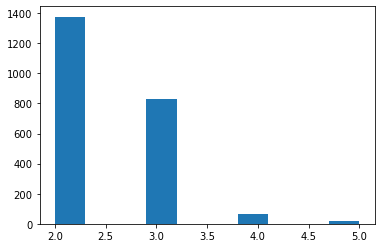

In [5]:
#Use Histogram to check the distribution
plt.hist(comments.OverallConditionrating1_5)

In [6]:
#Count the number of rating
comments.OverallConditionrating1_5.value_counts().sort_values(ascending=False)

2.0    1376
3.0     827
4.0      65
5.0      21
Name: OverallConditionrating1_5, dtype: int64

As we can see, we don't have any rated 1 comments. Also, the very good asset only have 21 assets. These minor assets may lead to serious imbalance. There are a few ways usually to remove the imbalance, including 

1) Collect More Data (Possible)

2) Resample the imbalanced data to make the imbalanced data balacned (if collecting more data is not feasible)

3) Use performance evaluation metrics, specially for imbalanced data (if previous approaches not available)

4) Cross-Validation (can definetely use this!)

5) Use Boosting approaches (can definetely try this!)

Reference: https://medium.com/@itbodhi/handling-imbalanced-data-sets-in-machine-learning-5e5f33c70163


After checking our previous databases, I do find more data that can be used to increase the number of rating 4 and 5. Import additional data and explore this data.

In [7]:
#Load Comments Data
add_comments = pd.read_excel('../data/raw/Additional Comments.xlsx')

#Preview Data
add_comments.head()

,Condition Rating,Comments,Category
0,2,This asset was observed in Good Condition. Ver...,PPE
1,3,This asset was assumed in fair condition. Corr...,PPE
2,3,This asset was observed in Fair Condition. Cor...,PPE
3,5,This asset was observed in Poor Condition. Min...,PPE
4,5,This asset was observed in Poor Condition. Min...,PPE


In [8]:
#Count the number of rating
add_comments['Condition Rating'].value_counts().sort_values(ascending=False)

2    723
3    364
5     34
4     31
Name: Condition Rating, dtype: int64

In [9]:
#Although there are not many 4 and 5 data, but still, we can add them in the current database.
add_comments_45 = add_comments[(add_comments['Condition Rating'] == 4) | (add_comments['Condition Rating'] == 5)]
add_comments_45.head()

,Condition Rating,Comments,Category
3,5,This asset was observed in Poor Condition. Min...,PPE
4,5,This asset was observed in Poor Condition. Min...,PPE
50,5,This asset was observed in Poor Condition. Cor...,PPE
51,5,This asset was observed in Poor Condition. Min...,PPE
81,5,This asset was observed in Poor Condition. The...,PPE


In [10]:
#Rename the columns to be consistent with the Comments dataframe
Columns = {'Condition Rating':'OverallConditionrating1_5', 'Comments':'InspectorsComments', 'Category':'Discipline'}
add_comments_45.rename(columns = Columns, inplace = True)
add_comments_45.head()

/Users/andygong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,OverallConditionrating1_5,InspectorsComments,Discipline
3,5,This asset was observed in Poor Condition. Min...,PPE
4,5,This asset was observed in Poor Condition. Min...,PPE
50,5,This asset was observed in Poor Condition. Cor...,PPE
51,5,This asset was observed in Poor Condition. Min...,PPE
81,5,This asset was observed in Poor Condition. The...,PPE


In [11]:
#Drop the unnecessary column
comments=comments.drop(columns='Keyword').dropna(axis=0, how='any')

In [12]:
#Append the add_comments45
comments_add = comments.append(add_comments_45, ignore_index=True)
comments_add.head()

,Discipline,OverallConditionrating1_5,InspectorsComments
0,Process Electrical,2.0,"Fixtures were in good condition, however they ..."
1,Building and Process Structural,3.0,The concrete foundation could not be inspected...
2,Building and Process Structural,3.0,The steel tank was observed to be in fair cond...
3,Building Services,5.0,Exhaust Fan 1 was missing.
4,Process Mechanical Equipment,3.0,Sewage Lift Pump 1 was in fair condition with ...


In [13]:
comments_add.OverallConditionrating1_5.value_counts().sort_values(ascending=False)

2.0    1332
3.0     827
4.0      96
5.0      55
Name: OverallConditionrating1_5, dtype: int64

In [14]:
comments = comments_add

## 2.2 Data Cleaning

### 2.2.1 Cleaning Discipline Data

The first thing to be cleaned is the Discipline. Utimately, we wanted to use the different categorical data to be a useful classification feature, as different categories may have impact of the rating.

In [15]:
#Explore the discipline data
comments.Discipline.value_counts()

Building and Process Structural    460
Process Mechanical Equipment       370
Process Electrical                 208
Building Services                  171
Building Architectural             153
Process Instrumentation SCADA      135
Process Piping                     119
SC                                 114
PM                                 114
Process Mechanical                  74
AC                                  54
SW                                  45
BM                                  40
Building Mechanical                 39
Architectural                       38
PPE                                 37
Structural                          35
ES                                  24
BA                                  22
Building Mechanical                 14
Process Mechanical                  10
HSS                                 10
Instrumentation and Control          7
Electrical                           7
SIC                                  6
PE                       

In [20]:
comments.Discipline = comments.Discipline.replace({
    'Building and Process Structural' : 'SC',
    'Process Mechanical Equipment' : 'PM',
    'Process Electrical' : 'ES',
    'Building Services' : 'ES',
    'Building Architectural': 'AC',
    'Process Piping': 'PM',
    'Process Mechanical': 'PM',
    'Building Mechanical': 'BM',
    'Architectural': 'AC',
    'Structural': 'SC',
    'Instrumentation and Control': 'SC',
    'Electrical': 'ES',
    'Process Instrumentation SCADA':'SIC',
    'Process Mechanical ':'PM',
    'Building Mechanical ': 'BM',
    'Instrumentation and Control ': 'SIC',
    'PPE':'PM',
    'BA':'AC',
    'BS':'SC',
    'PE':'ES'})
comments.Discipline.value_counts()

PM     724
SC     610
ES     413
AC     267
SIC    148
BM      93
SW      45
HSS     10
Name: Discipline, dtype: int64

In [21]:
comments.loc[comments.Discipline.str.contains('Process'), 'Discipline'] = 'PM'
comments.loc[comments.Discipline.str.contains('Building'), 'Discipline'] = 'BM'
comments.loc[comments.Discipline.str.contains('Instrumentation'), 'Discipline'] = 'SIC'

In [22]:
comments.Discipline.value_counts()

PM     724
SC     610
ES     413
AC     267
SIC    148
BM      93
SW      45
HSS     10
Name: Discipline, dtype: int64

### 2.2.2 Clean Condition Rating

In [26]:
# Convert the condition rating from Float to Int
comments['Insp'] = comments['OverallConditionrating1_5'].astype(int)
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Discipline                 2310 non-null   object
 1   OverallConditionrating1_5  2310 non-null   int64 
 2   InspectorsComments         2310 non-null   object
dtypes: int64(1), object(2)
memory usage: 54.3+ KB


### 2.2.3 Clean Inspector's Comments Data

In [29]:
for index,text in enumerate(comments['InspectorsComments'][35:40]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 Sewage Lift Pump 2 Discharge Check Valve was in fair condition. Severe surface corrosion was observed.
Review 2:
 Sewage Lift Pump 2 was in fair condition. Corrosion was observed on the visible parts of the pump. No performance issues were reported , however the pump was approaching the end of its remaining service life.
Review 3:
 The concrete roof was observed to be in fair condition. Minor wear with exposed aggregates was noted on the underside.
Review 4:
 Aluminum ladder was observed to be in fair condition. Anchor bolts, washers and nuts were noted to be corroded. Deposits were noted throughout.
Review 5:
 Main Breaker was in good condition.


For the text data, we may want clean a few things before moving to the EDA step:

1) Lower case all words

2) Remove any punctuations

3) Remove stop words

4) Lemmatization to make words to its base form (e.g. 'moving' can be lemmatized to 'move')

In [30]:
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

In [31]:
#Lowercase the Insepctor's Comments
comments['processing']=comments['InspectorsComments'].apply(lambda x: x.lower())
comments['processing'].head()

0    fixtures were in good condition, however they ...
1    the concrete foundation could not be inspected...
2    the steel tank was observed to be in fair cond...
3                           exhaust fan 1 was missing.
4    sewage lift pump 1 was in fair condition with ...
Name: processing, dtype: object

In [34]:
#Remove any punctuations
comments['processing']=comments['processing'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [35]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Discipline                 2310 non-null   object
 1   OverallConditionrating1_5  2310 non-null   int64 
 2   InspectorsComments         2310 non-null   object
 3   processing                 2310 non-null   object
dtypes: int64(1), object(3)
memory usage: 72.3+ KB


In [38]:
#Remove stop words and lemmatization the words
# Importing spacy
import spacy
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
# Lemmatization with stopwords removal
comments['lemmatized']=comments['processing'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [39]:
comments.head()

,Discipline,OverallConditionrating1_5,InspectorsComments,processing,lemmatized
0,ES,2,"Fixtures were in good condition, however they ...",fixtures were in good condition however they d...,fixture good condition mechanical protection
1,SC,3,The concrete foundation could not be inspected...,the concrete foundation could not be inspected...,concrete foundation inspect bury foundation as...
2,SC,3,The steel tank was observed to be in fair cond...,the steel tank was observed to be in fair cond...,steel tank observe fair condition corrosion no...
3,ES,5,Exhaust Fan 1 was missing.,exhaust fan 1 was missing,exhaust fan 1 miss
4,PM,3,Sewage Lift Pump 1 was in fair condition with ...,sewage lift pump 1 was in fair condition with ...,sewage lift pump 1 fair condition moderate sur...


The data has been cleaned completely.

# 3.0 Explorartory Data Analysis <a id="3.0_Explorartory_Data_Analysis"></a>

## 3.1 Discipline

Distribution of disciplines of review can be explored by ploting the histogram and label each bar

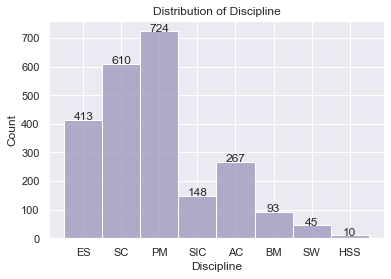

In [56]:
#Set theme of Seaborn
sns.set_theme()
# plot histogram 
ax = sns.histplot(data=comments, x="Discipline", color='#9d94ba')
ax.set(title='Distribution of Discipline')
# label each bar in histogram
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
            y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center') # sets horizontal alignment (ha) to center

PM has the most assets, while HSS has the least assets.

[Text(0.5, 1.0, 'Distribution of Discipline, with Condition Rating')]

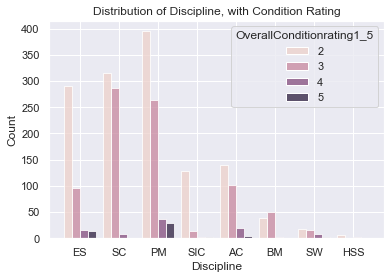

In [67]:
#Present the histogram with rating
ax = sns.histplot(data=comments, x="Discipline", color='#9d94ba', hue='OverallConditionrating1_5', 
                  multiple="dodge",shrink=.8)
ax.set(title='Distribution of Discipline, with Condition Rating')

## 3.2 Condition Rating

Distribution of condition rating of review can be explored by ploting the histogram and label each bar

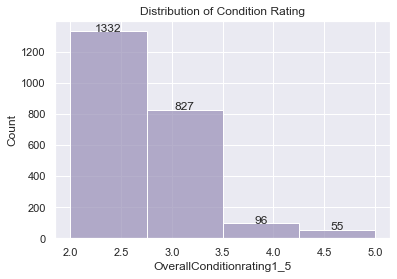

In [65]:
#Set theme of Seaborn
sns.set_theme()
# plot histogram 
ax = sns.histplot(data=comments, x="OverallConditionrating1_5", color='#9d94ba', bins=4)
ax.set(title='Distribution of Condition Rating')
# label each bar in histogram
for p in ax.patches:
    height = p.get_height() # get the height of each bar
    # adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
            y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
    s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
    ha = 'center') # sets horizontal alignment (ha) to center

## 3.3 Word Cloud

### 3.3.1 Word Cloud by Discipline

In [43]:
comments_grouped=comments[['Discipline','lemmatized']].groupby(by='Discipline').agg(lambda x:' '.join(x))
comments_grouped.head()

,lemmatized
Discipline,
AC,metal roof observe fair condition section roof...
BM,moderate surface corrosion observe moderate su...
ES,fixture good condition mechanical protection e...
HSS,minor surface corrosion eye wash station obser...
PM,sewage lift pump 1 fair condition moderate sur...


In [45]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer
c_vec=CountVectorizer(analyzer='word')
data=c_vec.fit_transform(comments_grouped['lemmatized'])
com_dtm = pd.DataFrame(data.toarray(), columns=c_vec.get_feature_names())
com_dtm.index=comments_grouped.index
com_dtm.head(3)

,00002251,00042968,00044244,00079718,06,10,1020,1065,1070,12,...,winter,wire,wit,wood,work,workingatmospheric,wrap,wrong,year,zone
Discipline,,,,,,,,,,,,,,,,,,,,,
AC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
BM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ES,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,2,0


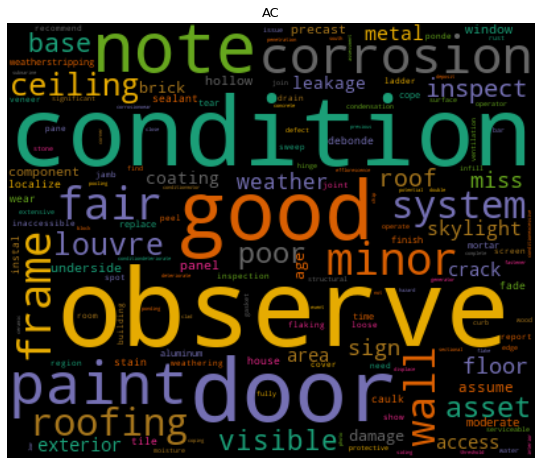

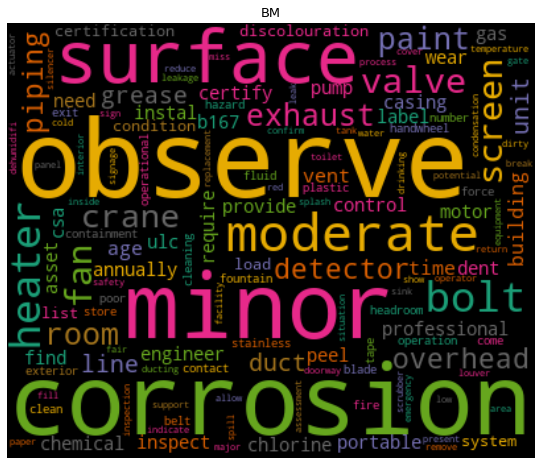

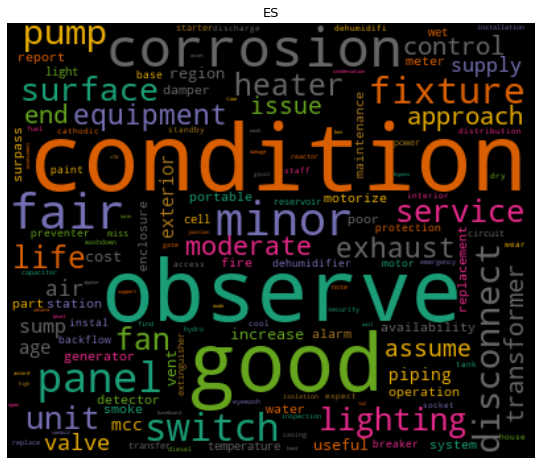

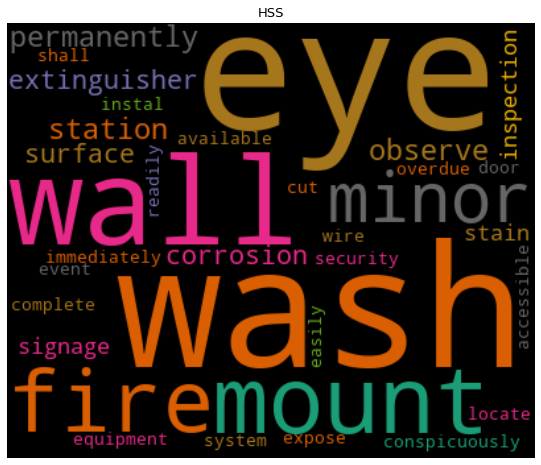

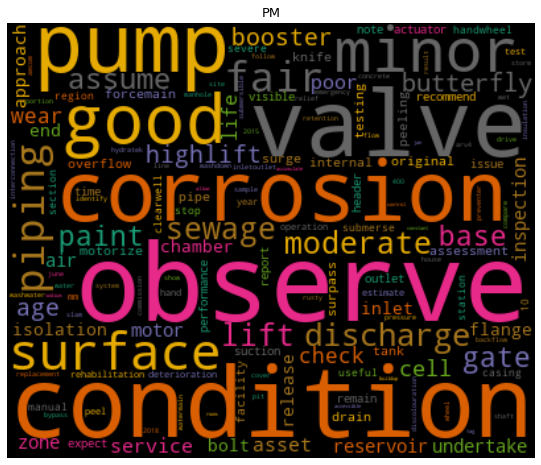

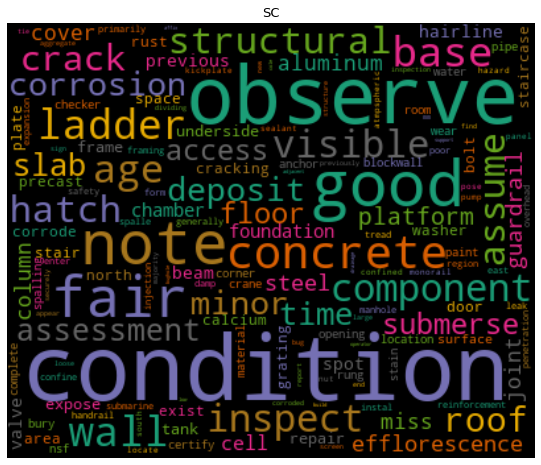

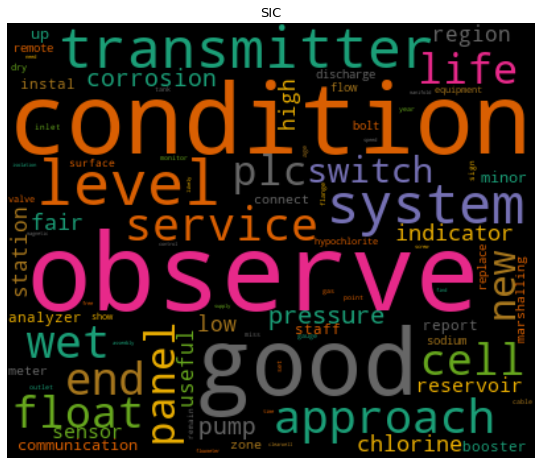

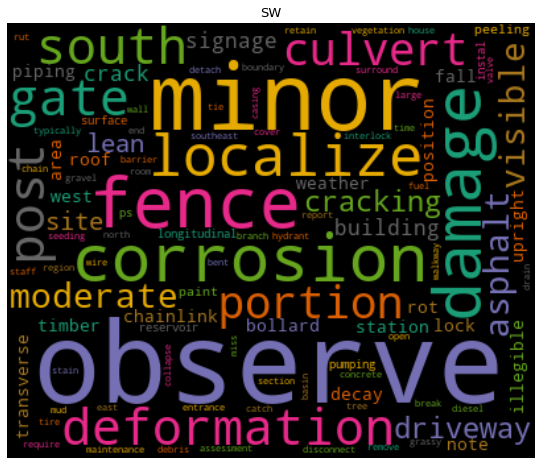

In [51]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()
# Transposing document term matrix
com_dtm=com_dtm.transpose()
# Plotting word cloud for each product
for index,dis in enumerate(com_dtm.columns):
    generate_wordcloud(com_dtm[dis].sort_values(ascending=False),dis)

"Condition" is absolutely a high-frequent word for all disciplines, but doesn't have any meaning.

"Good" is a also high-frequent word but not appear in every discipline.

### 3.3.2 Word Cloud by Condition Rating

In [73]:
r_comments=comments[['OverallConditionrating1_5','lemmatized']]
r_comments['OverallConditionrating1_5']=r_comments['OverallConditionrating1_5'].astype(str)
r_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   OverallConditionrating1_5  2310 non-null   object
 1   lemmatized                 2310 non-null   object
dtypes: object(2)
memory usage: 36.2+ KB


/var/folders/sc/zm445gtj461388gkngwypfbw0000gn/T/ipykernel_12528/1737639808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_comments['OverallConditionrating1_5']=r_comments['OverallConditionrating1_5'].astype(str)


In [74]:
r_comments_grouped=r_comments.groupby(by='OverallConditionrating1_5').agg(lambda x:' '.join(x))
r_comments_grouped.head()

,lemmatized
OverallConditionrating1_5,
2,fixture good condition mechanical protection m...
3,concrete foundation inspect bury foundation as...
4,roof observe poor condition corrode expose reb...
5,exhaust fan 1 miss forcemain poor condition re...


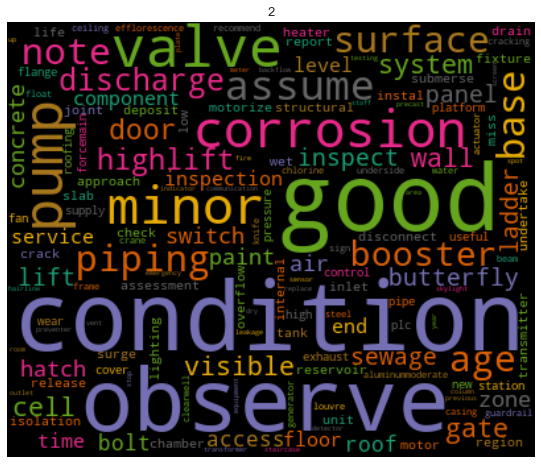

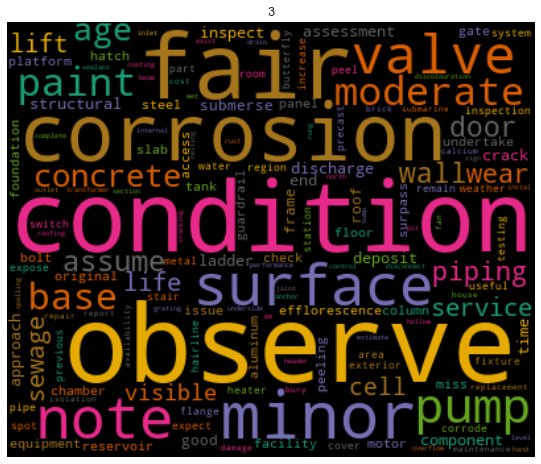

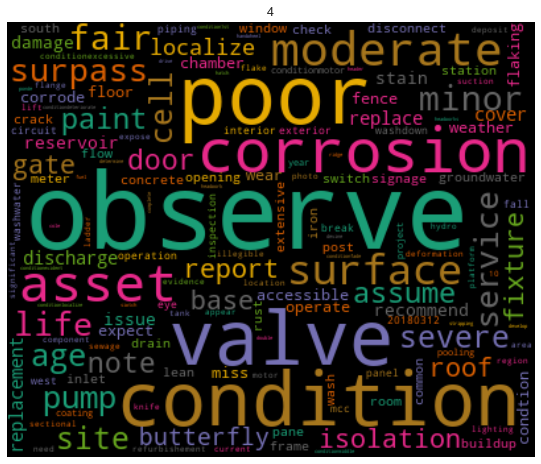

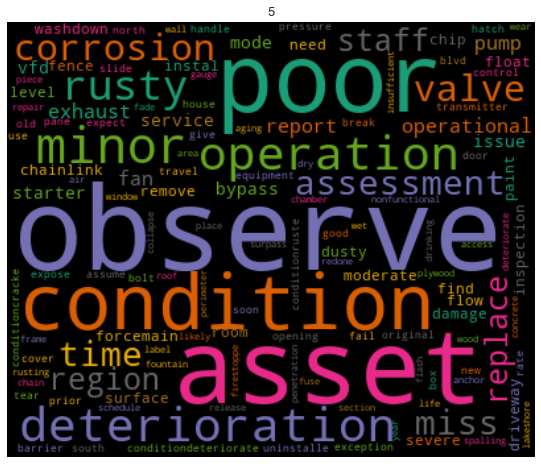

In [75]:
c_vec=CountVectorizer(analyzer='word')
data=c_vec.fit_transform(r_comments_grouped['lemmatized'])
c_com_dtm = pd.DataFrame(data.toarray(), columns=c_vec.get_feature_names())
c_com_dtm.index=r_comments_grouped.index

# Transposing document term matrix
c_com_dtm=c_com_dtm.transpose()
# Plotting word cloud for each product
for index,condition in enumerate(c_com_dtm.columns):
    generate_wordcloud(c_com_dtm[condition].sort_values(ascending=False),condition)

"Observe" and "condition" is a very high frequent word in any rating.

The word "Good", "Fair", "Poor" have very strong meaning of the conditions.

# 4.0 Pre-processing and Training Data Development <a id="4.0_Pre-processing_and_Training_Data_Development"></a>

# 5.0 Training and Testing <a id="5.0_Training_and_Testing"></a>

# 6.0 Modelling <a id="6.0_Modelling"></a>

# 7.0 Next Steps <a id="7.0_Next_Steps"></a>